In [2]:
# Section: 过拟合和欠拟合
'''
内容：

设置
希格斯数据集
演示过一遍
    训练过程
    微模型
    小模型
    中等模型
    大模型
    临近的训练和验证损失
    在TensorBoard中查看
防止过于庞大的策略
    添加权重正则化
    添加随机失活
    L2+随机失活的结合
    在TensorBoard中查看
结论

您的模型将过度拟合训练数据。学习如何处理过度拟合很重要。尽管通常可以在训练集上实现高精度，但您真正想要的是开发能够很好地推广到测试集（或他们以前从未见过的数据）的模型。

过拟合的反面是欠拟合，当训练数据仍有改进空间时，就会出现欠拟合，
发生这种情况的原因有很多，如果模型不够强大，过度正则化，或者训练时间不够长，这意味着网络尚未学习训练中的相关模式

如果训练时间过长，模型将开始过度拟合，并从训练数据中学习模式
而这些模式无法推广到测试数据，你需要取得平衡。

更完整的数据上训练的模型自然能够更好地进行泛化，如果没有更完整的数据，
则第二好的解决方案是使用正则化之类的技术


'''

# SECTION 设置：

import tensorflow as tf

print(tf.__version__)


2.13.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

# tempfile.mkdtemp() :以最安全的方式创建一个临时目录，用户用完临时目录序自行进行删除，并返回新目录的绝对路径

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
# 表示递归删除文件夹下所有的子文件夹和子文件，
# ignore_errors=True 删除失误的错误将被忽略
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
# SECTION: 希格斯数据集
'''
本教程的目的不是量子物理学，因此无需关注数据集的细节
包含11000000个样本，每个样本有28个特征和一个二元类标签

'''
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [5]:
FEATURES = 28
# tf.data.experimental.CsvDataset类可用于直接从 Gzip 文件读取 CSV 记录，而无需中间的解压步骤。
ds = tf.data.experimental.CsvDataset(gz, [float(), ]*(FEATURES + 1), compression_type="GZIP")

# CSV读取器类会为每条记录返回一个标量列表，
# 下面的函数会将此标量列表重新打包为（feature_vector, label）
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    # print(features)
    return features, label

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


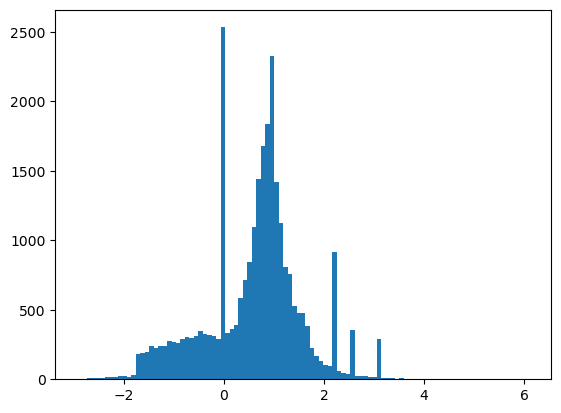

In [6]:
'''
tensorflow在运算大批次数据时效率最高

因此不要单独重新打包每一行，而是创建一个新的tf.data.Dataset
该数据集会接受一10000个样本为单位的批次。
将pack_row函数用于每个批次，然后将批次重新拆分为单个记录

- .batch(batch_size=10000, iteration)
    将整个训练样本分成若干个batch
    Batch_size: 每批样本的大小， 一次训练所选取的样本数
    Iteration:训练一个batch就是一个iteration（类似于迭代器）

- .map
    map接收一个函数，Dataset中的每个元素都会被当作这个函数的输入，
    并将函数返回值作为新的Dataset

- .unbatch
    将数据集的元素拆分为批次维度上的多个元素
'''
packed_ds = ds.batch(10000).map(pack_row).unbatch()

# 检查这个新的packed_ds中的一些记录
# 虽然没有特征完全归一化，但对于本教程已经足够了

for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [7]:
# 为了缩短时间。只使用前1000个样本进行验证，再用接下来的10000个样本进行训练

'''

'''
N_VALIDATTION = int(1e3)
N_TRAIN = int(1e4)
BUFFRT_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATTION).cache()
train_ds = packed_ds.skip(N_VALIDATTION).take(N_TRAIN).cache()
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [8]:
'''
这些数据集会返回单个样本。使用dataset.batch方法创建适当大小的批次进行训练，在批次创建之后，还要记得在训练集上使用dataset.shuffle和dataset.repeat

shuffle是按顺序将数据放入buffer里面的；
当repeat函数在shuffle之后的话，是将一个epoch的数据集抽取完毕，再进行下一个epoch的。

shuffle(shuffle_size) 将数据打乱，数值越大，混乱程度越大
'''
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFRT_SIZE).repeat().batch(BATCH_SIZE)


# SECTION: 演示过拟合

要避免过拟合最简单的方式是从小模型开始，小模型是指具有少量可学习参数（由层数和每层的单元数决定）的模型。在深度学习中，模型中可学习参数的数量通常被称为模型的容量

- 深度学习模型往往擅长拟合训练数据，但真正的挑战是泛化而非拟合

要找到合适的模型大小，最好先使用相对较少的层和参数，然后增加层的大小或添加新层，知道看到返回的验证损失逐渐减少

先从仅使用密集连接层（tf.keras.layers.Dense）作为基线的简单模型开始，然后创建更大的模型并进行对比

# SECTION: 训练过程

如果在训练期间逐渐减小学习率，许多模型的训练效果会更好。
请使用（tf.keras.optimizers.schedules）随着时间推移减小学习率


## tf.keras.optimizers.schedules.InverseTimeDecay：
随着训练学习率衰减
- 逆时衰减(Inverse Time Decay) 参数：
    - nitial_learning_rate:初始学习率
    - decay_steps: 每隔多少步进行学习率衰减
    - decay_rate: 学习率衰减率
    - staircase：衰减方式
- 逆时衰减的计算方式如下：
```python
if staircase == True:
     decayed_learning_rate = learning_rate / (1 + decay_rate * floor(global_step / decay_step))
 else:
     decayed_learning_rate = learning_rate / (1 + decay_rate * global_step / decay_step)

```

# 学习率
学习率决定了学习进程的快慢（也可以看作是步幅的大小）

如果学习率过大，很可能会越过最优值，反而如果学习率过小，优化的效率可能很低，导致过长的运算时间，所以学习率对于算法性能的表现十分重要。而优化器keras.optimizers.Adam()是解决这个问题的一个方案。其大概的思想是开始的学习率设置为一个较大的值，然后根据次数的增多，动态的减小学习率，以实现效率和效果的兼得。


In [9]:
'''
 以下设置的tf.keras.optimizers.schedules.InverseTimeDecay用于在1000个周期时将学习率根据双曲线的形状降至基础速率的1/2，在2000个周期时将至1/3，依次类推
'''
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

tf.Tensor(
[0.001      0.00090741 0.00083051 0.00076563 0.00071014 0.00066216
 0.00062025 0.00058333 0.00055056 0.00052128 0.00049495 0.00047115
 0.00044954 0.00042982 0.00041176 0.00039516 0.00037984 0.00036567
 0.00035252 0.00034028 0.00032886 0.00031818 0.00030818 0.00029878
 0.00028994 0.00028161 0.00027374 0.0002663  0.00025926 0.00025258
 0.00024623 0.0002402  0.00023445 0.00022897 0.00022374 0.00021875
 0.00021397 0.0002094  0.00020502 0.00020082 0.00019679 0.00019291
 0.00018919 0.00018561 0.00018216 0.00017883 0.00017563 0.00017254
 0.00016955 0.00016667], shape=(50,), dtype=float32)


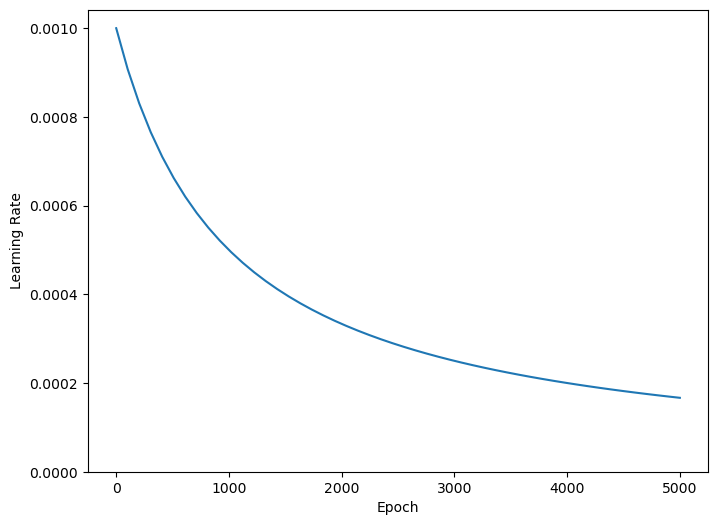

In [10]:
step = np.linspace(0, 100000)
# num默认值为50
lr = lr_schedule(step)
print(lr)
plt.figure(figsize = (8, 6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

本教程中的每个模型都将使用相同的训练配置。因此，从回调列表开始，以可重用的方式对其进行设置

本教程的训练会运行许多个较短周期，为了降低日志记录噪声，请使用tfdocs.EPOCHDOTs,他仅会为每个周期打印一个.， 并每个100个周期打印一整套指标

**然后添加 tf.keras.callbacks.EarlyStopping 以避免冗长和不必要的训练时间。请注意，设置此回调是为了监视 val_binary_crossentropy，而不是 val_loss。这个区别在后面会很重要。**

- Binary cross entropy 二元交叉熵是二分类问题中常用的一个Loss损失函数

使用 callbacks.TensorBoard 为训练生成 TensorBoard 日志。

In [11]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        # patience: 在监控指标没有提升的情况下，epochs 等待轮数。等待大于该值监控指标始终没有提升，则提前停止训练
        tf.keras.callbacks.EarlyStopping
        (monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name)
    ]

In [12]:
# 类似的， 每个模型将使用相同的model.compile和model.fit设置
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),# 激活函数，归一化
                  metrics = [
                      tf.keras.metrics.BinaryCrossentropy(
                          from_logits=True, name='binary_crossentropy'
                      ),
                      'accuracy'
                  ])

    # 输出模型各层的状况
    model.summary()

    # 训练模型，并返回loss和测量指标
    # verbose:0:不输出信息；1:显示进度条(一般默认为1)；2:每个epoch输出一行记录；
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data = validate_ds,
        callbacks = get_callbacks(name),
        verbose=0
    )

    return history

In [13]:
# SECTION: 微模型
# 从训练下面的模型开始

tiny_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4749,  binary_crossentropy:0.7476,  loss:0.7476,  val_accuracy:0.4660,  val_binary_crossentropy:0.7232,  val_loss:0.7232,  
....................................................................................................
Epoch: 100, accuracy:0.5904,  binary_crossentropy:0.6308,  loss:0.6308,  val_accuracy:0.5830,  val_binary_crossentropy:0.6299,  val_loss:0.6299,  
............................

(0.5, 0.7)

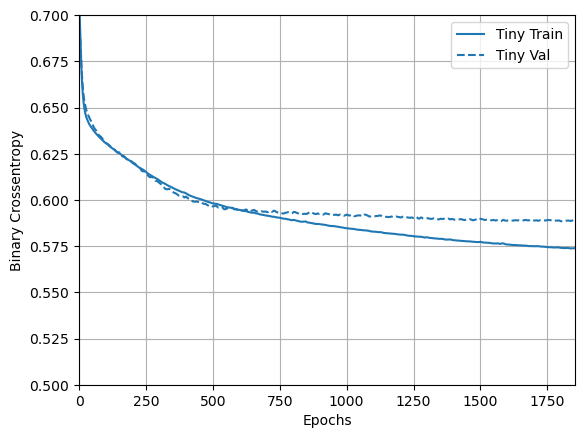

In [14]:
# 查看一下模型表现
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [16]:
# SECTION: 小模型
'''
要检查是否超过小模型的表现，需要逐步训练一下更大的模型

尝试两个隐藏层， 其中每层包含16个单元
'''

small_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(1)
])

size_histories['Small'] = compile_and_fit(small_model, 'sizess/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4922,  binary_crossentropy:0.7039,  loss:0.7039,  val_accuracy:0.4660,  val_binary_crossentropy:0.6911,  val_loss:0.6911,  
....................................................................................................
Epoch: 100, accuracy:0.6236,  binary_cros

In [17]:
# SECTION: 中等模型

'''
现在尝试三个隐藏层，其中每层包含64个单元
'''
medium_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(1)
])

size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10241 (40.00 KB)
Trainable params: 10241 (40.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4987,  binary_crossentropy:0.7016,  loss:0.7016,  val_accuracy:0.4740,  val_binary_crossentropy:0.6886,  val_loss:0.6886,  
....

In [18]:
# SECTION: 大模型
'''
作为练习，您可以创建一个更大的模型，检查他开始过拟合的速度，
接下来为这个基准添加一个具有更大容量的网络，其容量远远超过解决问题的需要
'''
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512,activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(1)
])
# 同样的，使用相同的数据训练该模型
size_histories['large'] = compile_and_fit(large_model, 'sizes/large')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

# 绘制训练和验证损失

实现表示训练损失，虚线表示验证损失（验证损失越低表示模型越好）

虽然构建的模型越大能力越强，但如果不对这种能力进行限制，她很容易对训练集过拟合

在此实例中，通常只有“Tiny"模型可以完全避免过拟合，而其他较大的模型可以更快的拟合数据，对于large模型。过拟合的情况尤为严重，您必须将绘图切换为对数尺度才能真正弄清楚所发生的情侣

如果您绘制出验证指标将其与训练指标进行对比的话，就会很明显

- 有细微差别是正常的
- 如果有两个指标朝同一方向移动，说明一切正常
- 如果验证指标开始停滞，而训练指标继续提升，则可能即将出现过拟合
- 如果验证指标的方向错误。则模型显示已经过拟合

Text(0.5, 0, 'Epochs [log Scale]')

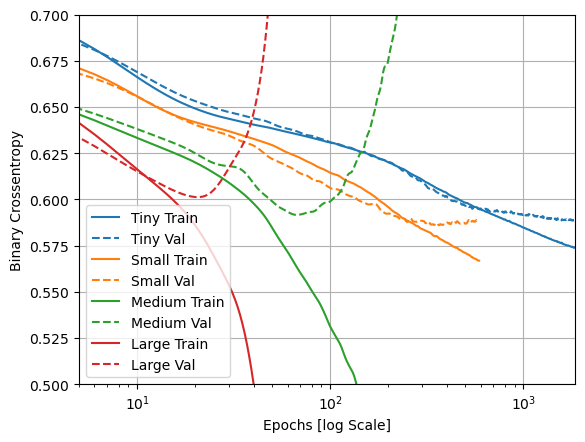

In [20]:
'''
上述运行的所有训练都使用了callbacks.EarlyStopping,会在发现模型没有进展后终止训练
'''
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [log Scale]")

In [24]:
# SECTION: 防止过拟合的策略
'''
再开始学习本部分内容之前，请先复制‘Tiny’模型的训练日志，用作比较基线

'''

# 递归删除文件
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizes/Tiny')

regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: 'C:\\Users\\17828\\AppData\\Local\\Temp\\tmp9jqfloaz\\tensorboard_logs\\regularizes\\Tiny'

# 添加权重正则化
在此文中简单模型是指参数值的分布具有更少的熵的模型。因此缓解过拟合的一种常用方式是限制网络的复杂性，方法时强制网络的权重值只取较小值，这样会使得权重值的分布更加规则，这被称为权重正则化，通过向网络的损失函数添加一个与较大权重相关的成本来实现，这种成本有两种方式

- L1正则化：其中添加的成本与权重系数的绝对值（即权重L1的范数）成正比
- L2正则化：其中添加的成本与权重系数值的平方（即权重的l2范数）成正比。L2正则化在神经网络中也被称为权重衰减，不要因为名称不同而感到困惑，

L1 正则化会促使权重向零靠近，鼓励稀疏模型。L2正则化会惩罚权重参数而不使其稀疏化，因为对于较小权重，惩罚会趋近于零，这也是L2更为常见的一个原因

在tf.keras中。添加权重正则化的方式是将权重正则化器实例作为关键参数传递给层，添加L2权重正则化：


In [25]:
'''
l2(0.001)表示层的权重矩阵中每个系数都会将0.001 * weight_coefficient_value ** 2 添加到网络的总损失中

这就是为什么我们要监视binary_crossentropy,因为他没有混入此正则化组件


因此带有L2正则化惩罚的相同Large模型表现更好
'''
l2_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

(0.5, 0.7)

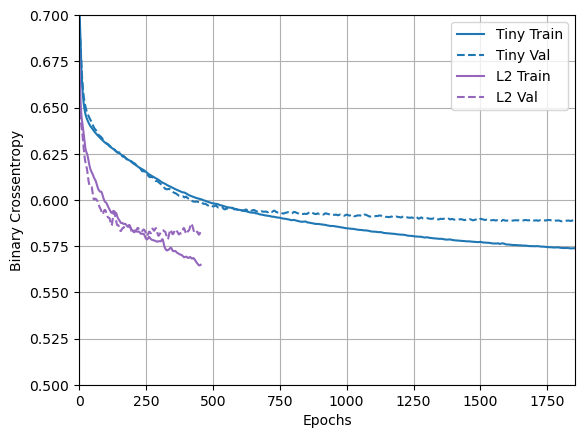

In [27]:
'''
如下图所示，“l2”正则化模型现在比Tiny模型更具竞争力，“L2"模型也比她所基于
的”Large“模型（具有相同数量的参数）更不容易过拟合
'''
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

# 添加随机失活

随机失活是一种最有效，最常用的神经网络正则化技术

随机失活的直观解释是，由于网络中的单个节点不能依赖其他节点的输出，所以每个节点必须输出对自己有用的特征

应用于层的时，随机失活会在训练期间对该层的多个输出特征进行随机失活（即设置为零）

随机失活率是指被清零的特征的比率，它通常设置为0.2到0.5之间，在测试时，没有单元会被随机失活，而是根据一个等于随机失活率的系数将层的输出值按比例缩小，进而实现平衡（因为会有更多单元在训练时被激活）

在keras中，可以通过tf.keras.layers.Dropout层在网络中引入随机失活，该层将应用于前一层的输出



In [28]:
# 向网络中添加两个随机失活层，检查他们在减少过拟合方面的表现

dropout_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)              

(0.5, 0.7)

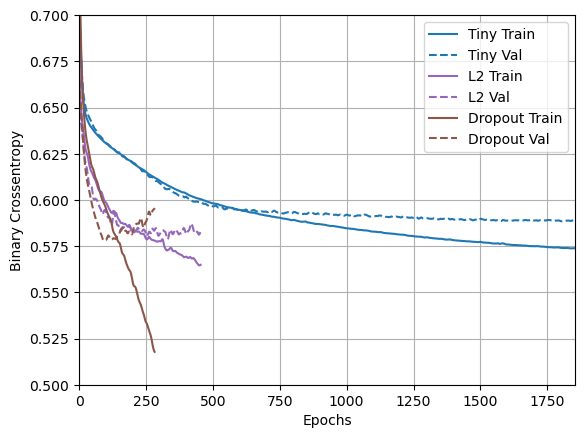

In [29]:
'''
一下的绘图都可以看清楚，这两种正则化都改善了“Large”模型的行为，
但依然没有超过“Tiny”基线
'''
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [ ]:
# SECTION: L2+随机失活的结合
'''
这个使用combined正则化的模型，显然是目前最好的模型
'''
combined_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)

])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)              

#SECTION: 结论

在神经网络中防止过拟合最常见的方式：
- 获取更多训练数据
- 降低网络容量
- 添加权重正则化
- 添加随机失活

- 数据增强
- 批次归一化

**单独使用每种方法也会有效，但结合起来通常效果更好**